This is the first, simplest workflow

In [9]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import os
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict, Annotated, Optional
from langchain.tools import tool
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt




In [10]:
load_dotenv()
api_key=os.getenv('API_KEY')
llm=ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    api_key=api_key
)

In [11]:
class AutoML(TypedDict):
    task: str
    messages: Annotated[list[BaseMessage], add_messages]
    target:str

In [ ]:
DATASET_REGISTRY = {}

def load_dataset(dataset_id: str, path: str):
    """Load dataset and store internally."""
    DATASET_REGISTRY[dataset_id] = pd.read_csv(path)


@tool

def rem_null_duplicates(dataset_id: str) -> dict:
    """Remove null values and duplicate rows from dataset."""
    df = DATASET_REGISTRY[dataset_id]
    before_shape = df.shape
    df = df.dropna().drop_duplicates()
    DATASET_REGISTRY[dataset_id] = df
    return {
        "before_rows": before_shape[0],
        "after_rows": df.shape[0],
        "columns": df.columns.tolist()
    }

@tool

def data_profile_tool(dataset_id: str) -> dict:
    """Generate dataset profile summary."""
    df = DATASET_REGISTRY[dataset_id]
    return {
        "rows": len(df),
        "columns": df.shape[1],
        "dtypes": df.dtypes.astype(str).to_dict(),
        "missing_values": df.isnull().sum().to_dict()
    }

@tool

def eda_tool(dataset_id: str) -> dict:
    """Perform basic EDA on numeric columns."""
    df = DATASET_REGISTRY[dataset_id]
    desc = df.describe(include='number').round(3)
    return desc.to_dict()


@tool

def correlation_tool(dataset_id: str, threshold: float = 0.7) -> dict:
    """Find strong correlations above a threshold."""
    df = DATASET_REGISTRY[dataset_id]
    corr = df.corr(numeric_only=True)
    strong_corr = (
        corr.where(abs(corr) >= threshold)
            .stack()
            .to_dict()
    )
    return {"strong_correlations": strong_corr}


@tool

def kpi_summary_tool(dataset_id: str) -> dict:
    """Generate high-level KPIs for the dataset."""
    
    df = DATASET_REGISTRY[dataset_id]
    numeric_cols = df.select_dtypes(include='number')
    return {
        "row_count": len(df),
        "column_count": df.shape[1],
        "numeric_columns": numeric_cols.columns.tolist(),
        "mean_values": numeric_cols.mean().round(3).to_dict()
    }



@tool
def encode_categorical_tool(dataset_id: str) -> dict:
    """Label-encode all categorical columns."""
    
    df = DATASET_REGISTRY[dataset_id].copy()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    
    DATASET_REGISTRY[dataset_id] = df
    
    return {
        "encoded_columns": cat_cols,
        "encoding_maps": encoders
    }
 
@tool
def groupby_summary_tool(dataset_id: str, group_col: str, agg: str = "mean") -> dict:
    """Perform group-by aggregation on numeric columns."""
    
    df = DATASET_REGISTRY[dataset_id]
    
    summary = df.groupby(group_col).agg(agg).round(3)
    
    return summary.to_dict()

@tool
def outlier_detection_tool(dataset_id: str) -> dict:
    """Detect outliers using IQR method for numeric columns."""
    
    df = DATASET_REGISTRY[dataset_id]
    numeric_cols = df.select_dtypes(include='number')
    
    outlier_report = {}
    
    for col in numeric_cols.columns:
        Q1 = numeric_cols[col].quantile(0.25)
        Q3 = numeric_cols[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        outliers = ((numeric_cols[col] < lower) | (numeric_cols[col] > upper)).sum()
        
        outlier_report[col] = int(outliers)
    
    return outlier_report


@tool
def plot_distribution_tool(dataset_id: str, column: str) -> dict:
    """Plot distribution of a column."""
    
    df = DATASET_REGISTRY[dataset_id]
    
    plt.figure()
    df[column].hist()
    path = f"{dataset_id}_{column}_dist.png"
    plt.savefig(path)
    plt.close()
    
    return {"plot_path": path}

@tool
def plot_correlation_heatmap_tool(dataset_id: str) -> dict:
    """Plot correlation heatmap."""
    
    df = DATASET_REGISTRY[dataset_id]
    corr = df.corr(numeric_only=True)
    
    plt.figure(figsize=(8,6))
    plt.imshow(corr)
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    
    path = f"{dataset_id}_corr_heatmap.png"
    plt.tight_layout()
    plt.savefig(path)
    plt.close()
    
    return {"plot_path": path}


In [13]:
tools=[rem_null_duplicates,data_profile_tool,eda_tool,correlation_tool,kpi_summary_tool, encode_categorical_tool,groupby_summary_tool, outlier_detection_tool, plot_distribution_tool, plot_correlation_heatmap_tool ]
llm_tools=llm.bind_tools(tools)

In [14]:
def chat_node(state: AutoML):
    messages = state["messages"]

    if not messages:
        messages = [HumanMessage(content=state["task"])]

    response = llm_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)  


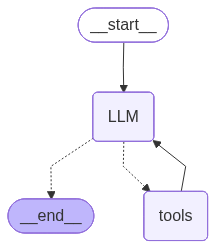

In [15]:
graph=StateGraph(AutoML)
graph.add_node("LLM",chat_node)
graph.add_node("tools",tool_node)

graph.add_edge(START, "LLM")
graph.add_conditional_edges("LLM",tools_condition)
graph.add_edge("tools","LLM")

workflow=graph.compile()
workflow

In [16]:
load_dataset("sales_data", "Walmart_Sales.csv")

task="In the given sales_data, tell me if there are any outliers"
result = workflow.invoke({"task": task, "messages": [], })
print(result["messages"][-1].content)


The outlier detection tool results show that the 'Store' and 'Unemployment' columns have outliers, while the 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', and 'CPI' columns do not have any outliers.
